# Homework 3

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx

from sklearn import linear_model
from sklearn import metrics
from networkx.algorithms import bipartite
from matplotlib.pyplot import cm
from operator import itemgetter

%matplotlib inline 

## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [2]:
df = pd.read_csv('lalonde.csv').set_index('id')

Let's make a categorical feature for the race.

In [3]:
df['race'] = 'white'
df.loc[df['black'] == 1, 'race'] = 'black'
df.loc[df['hispan'] == 1, 'race'] = 'hispanic'
df['race'] = df['race'].astype('category')

In [4]:
df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,race
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,black
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,hispanic
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,black
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,black
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,black


### 1. A naive analysis

_Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization")._

_What might a naive "researcher" conclude from this superficial analysis?_


In [5]:
print('Treated group : {} individuals'.format(len(df.loc[df.treat == 1])))
print('Control group : {} individuals'.format(len(df.loc[df.treat == 0])))

Treated group : 185 individuals
Control group : 429 individuals


In [6]:
print('Treated group mean earnings in 1974 : {}'.format(int(df.loc[df.treat == 1, 're74'].mean())))
print('Control group mean earnings in 1974 : {}'.format(int(df.loc[df.treat == 0, 're74'].mean())))

Treated group mean earnings in 1974 : 2095
Control group mean earnings in 1974 : 5619


In [7]:
print('Treated group mean earnings in 1975 : {}'.format(int(df.loc[df.treat == 1, 're75'].mean())))
print('Control group mean earnings in 1975 : {}'.format(int(df.loc[df.treat == 0, 're75'].mean())))

Treated group mean earnings in 1975 : 1532
Control group mean earnings in 1975 : 2466


In [8]:
print('Treated group mean earnings in 1978 : {}'.format(int(df.loc[df.treat == 1, 're78'].mean())))
print('Control group mean earnings in 1978 : {}'.format(int(df.loc[df.treat == 0, 're78'].mean())))

Treated group mean earnings in 1978 : 6349
Control group mean earnings in 1978 : 6984


We now also want to show the means and standard deviations of the salary of treated and non-treated people before in all years:

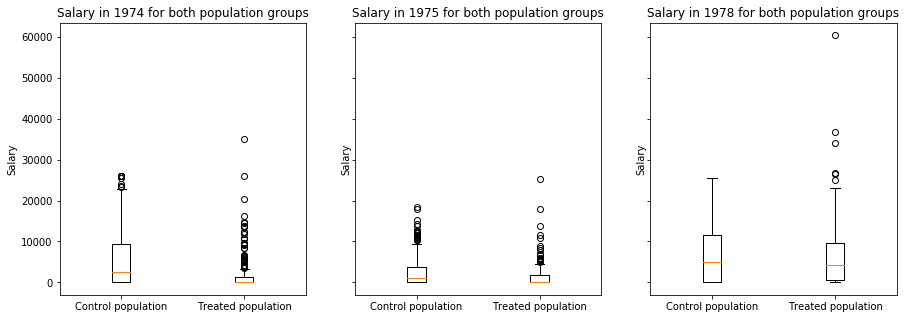

In [9]:
fig, axes = plt.subplots(1,3,sharey=True)
fig.set_size_inches(15,5)

cols = ['re74','re75','re78']
years = ['1974','1975','1978']

for i in range(3): # 0 = treated (axis 0), 1 = non-treated (axis 1)
    axes[i].boxplot([df.loc[df.treat==0, cols[i]].values, df.loc[df.treat==1, cols[i]].values])
    axes[i].set_xticklabels(['Control population', 'Treated population'])
    axes[i].set_title('Salary in ' + str(years[i]) + ' for both population groups')
    axes[i].set_ylabel('Salary') # TODO annual?

First, we can show the mean of all variables for treated and non-treated people:

### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

#### Means of features

In [10]:
df_mean_group = df.groupby('treat').mean().round(2)
df_mean_group

,age,educ,black,hispan,married,nodegree,re74,re75,re78
treat,,,,,,,,,
0,28.03,10.24,0.20,0.14,0.51,0.60,5619.24,2466.48,6984.17
1,25.82,10.35,0.84,0.06,0.19,0.71,2095.57,1532.06,6349.14


#### Distributions of features

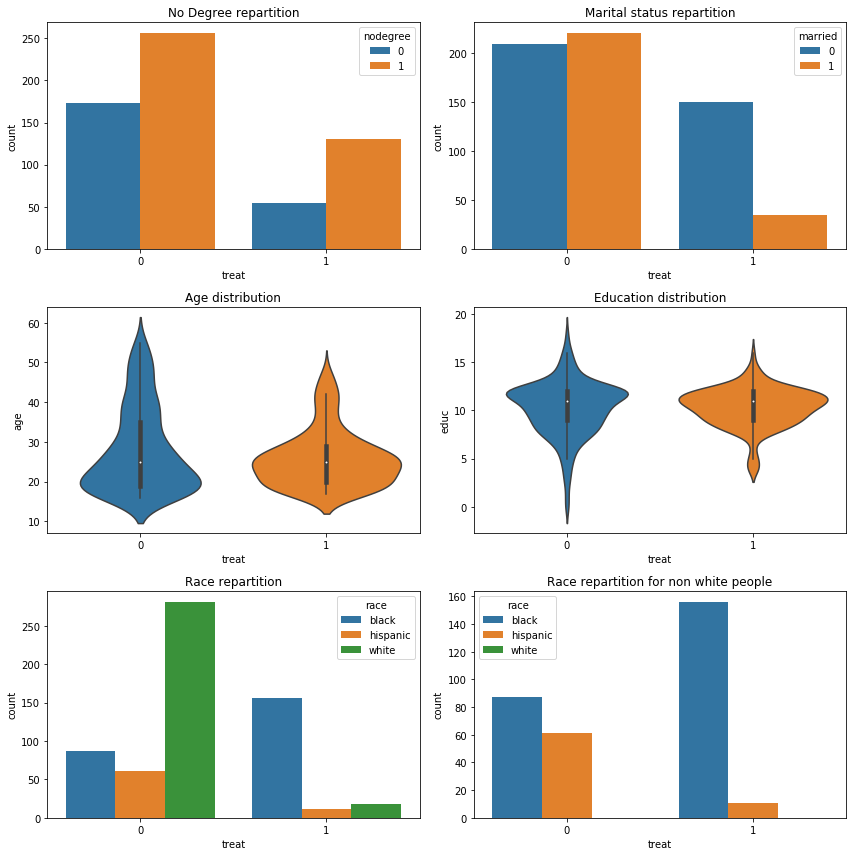

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

ax[0, 0].set_title("No Degree repartition")
sns.countplot(x='treat', hue='nodegree', data=df, ax=ax[0, 0])

ax[0, 1].set_title("Marital status repartition")
sns.countplot(x='treat', hue='married', data=df, ax=ax[0,1])

ax[1, 0].set_title("Age distribution")
sns.violinplot(x='treat', y='age', data=df, ax=ax[1, 0])

ax[1, 1].set_title("Education distribution")
sns.violinplot(x='treat', y='educ', data=df, ax=ax[1, 1])

ax[2, 0].set_title("Race repartition")
sns.countplot(x='treat', hue='race', data=df, ax=ax[2, 0])

ax[2, 1].set_title("Race repartition for non white people")
sns.countplot(x='treat', hue='race', data=df.loc[df.race != 'white', ['treat', 'race']], ax=ax[2, 1])

plt.tight_layout()
plt.show()

TODO : interpret the distributions ploted above.

Almost no white people in treat group. Almost only black people in treat group.

No married people in treat group. 



#### Distribution of revenues

In [12]:
diff_t_nt_74 = df_mean_group.loc[0].re74 - df_mean_group.loc[1].re74
diff_t_nt_75 = df_mean_group.loc[0].re75 - df_mean_group.loc[1].re75
diff_t_nt_78 = df_mean_group.loc[0].re78 - df_mean_group.loc[1].re78
print("Difference between groups in 1974: " + str(np.round(diff_t_nt_74,2)))
print("Difference between groups in 1975: " + str(np.round(diff_t_nt_75,2)))
print("Difference between groups in 1978: " + str(np.round(diff_t_nt_78,2)))

Difference between groups in 1974: 3523.67
Difference between groups in 1975: 934.42
Difference between groups in 1978: 635.03


Indeed, the difference between the groups got smaller from 1974 to 1978, although salaries got higher on avarage for both groups!

Let's plot the histograms of the distribution of revenues rounded to the closest thousand.

In [13]:
treated_x = df.loc[df.treat == 1, 're78'].values.round(-3)
control_x = df.loc[df.treat == 0, 're78'].values.round(-3)

x_treated, y_treated = np.unique(treated_x, return_counts=True)
x_treated = (x_treated/1000).astype(int)

x_control, y_control = np.unique(control_x, return_counts=True)
x_control = (x_control/1000).astype(int)

In [14]:
def plot_histogram(df, columns, treated, title, legend, figsize=(20,10), counts = False):
    """
    This functions plots a histogram adding the values on top of the bins.

    x: values of the attribute that is being counted
    y: counts of the x values
    title: title to give to the histogram
    abscissa: absissa to be displayed (what is being counted)
    """    
    color = cm.RdGy(np.linspace(0, 1, 4))
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    width = figsize[0]/100*(len(columns)+len(treated))/2 # the width of the bars
    offset = figsize[0]/50 # distance between two bars

    i = 0
    for t in treated:
        for c in columns:
            
            
            if counts == True:
                x, y = np.unique(df.loc[df.treat == t, c],return_counts = True)
                y = y/ len(df[df.treat == t])
                
                ind = np.arange(len(y))
                #ind = ['true','false']
            else:
                x_treated = df.loc[df.treat == t, c].values.round(-3)
                x_treated, y = np.unique(x_treated, return_counts=True)
                y = y/len(df.loc[df.treat == t, c])
                x = (x_treated/1000).astype(int)
                ind = np.arange(len(y))
            ax.bar(ind + offset*i, y, width, color=color[i])
            ax.set_xticks(ind)
            ax.set_xticklabels(x, minor=False)


            #for j, v in enumerate(y):
            #    ax.text(j-width/6, v + 1, str(v), color=color[i])
            i = i + 1
        
    fig.suptitle(title, fontsize=15)
    plt.grid()
    plt.xlabel('Revenue')
    plt.ylabel('Percentage of population')
    plt.legend(legend)
    fig.subplots_adjust(top=0.9)
    plt.show()
    


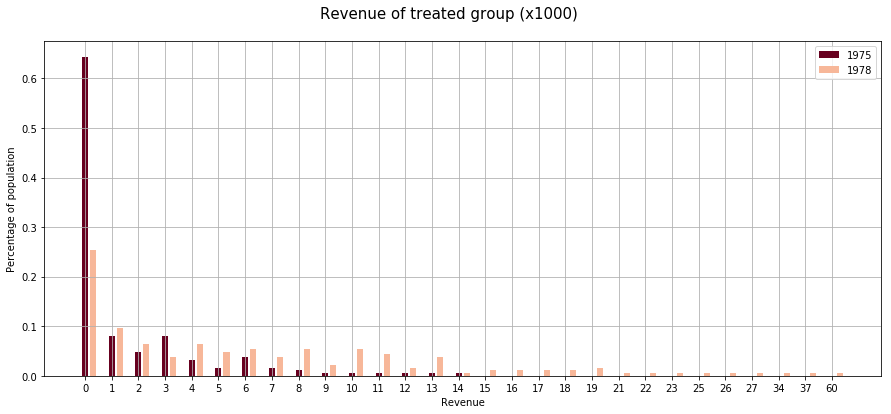

In [15]:
plot_histogram(df, ['re75','re78'], [1], legend = ['1975','1978'], title='Revenue of treated group (x1000)', figsize=(15,6))

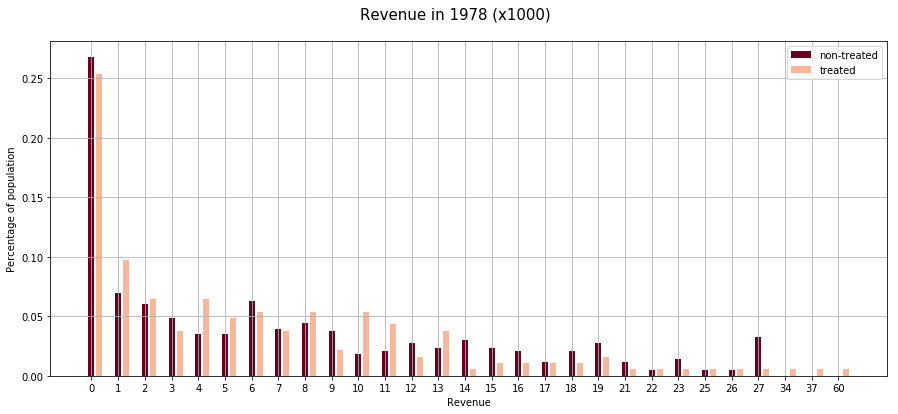

In [16]:
plot_histogram(df, ['re78'], [0,1], legend = ['non-treated','treated'], title='Revenue in 1978 (x1000)', figsize=(15,6))

#### Correlation matrix

In [17]:
def get_corr_matrix(df, mask_diag=True, f_size=(6,5)):
    
    f, ax = plt.subplots(figsize=f_size)
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    if mask_diag:
        mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr, mask=mask, cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax, annot=True)
    plt.show()

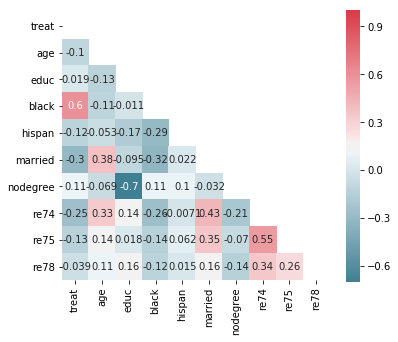

In [18]:
get_corr_matrix(df)

The correlation matrix confirms the assumption that `black` and `unmarried` are two features that are correlated with `treat`. Those categories seem more likely to be picked to receive the treatement.



### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

#### Hypothesis

Following people seem to have been favoured for treatment
- Black people (84% proportion treated vs 20% proportion non-treated);
- Unmarried people (19% vs 60%);
- People with lower incomes in 1974 and 1975.
More rigourous statistics need to be produced to confirm these assumptions.

#### Logistic model to compute propensity scores

As "pre-treatment" features, we select all the given features except for `treat` and `re78`.

In [19]:
clf = linear_model.LogisticRegression()

##### Prepare the data

In [20]:
# discard non pre-treatment features
X = np.asarray(df.drop(['treat','re78', 'race'], axis=1).values)
# get the labels
y = np.asarray(df['treat'].values)

##### Fit the model

In [21]:
# fit the logistic regression classifier
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

##### Get the propensity scores : the prediction probabilities

In [22]:
# get the probabilty that predicted label is 1 (treatement) (the propensity scores)
prop_scores = clf.predict_proba(X)[:, 1]

In [23]:
# insert probabilities to corresponding points in dataframe
df['propensity_score'] = prop_scores

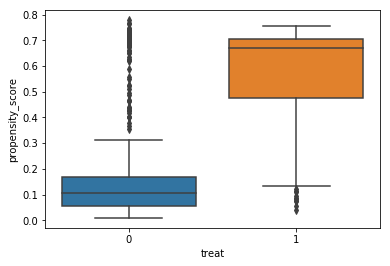

In [24]:
sns.boxplot(x='treat', y='propensity_score', data=df)

Those boxplots definetely show that the propensity scores of the treated group are way higher than the one of the control group.

### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

We will create a bipartite graph whose left nodes contain the indexes of people having been treated and as a right nodes contain indexes of people who have not been treated. We will connect all left and right nodes by the weight, which we calculate as the absolute difference between their propensities to be treated. Since `networkx` offers no way to minimize the weights, we will simply take the negative difference and then maximize the weights.

In [25]:
nodes_control = df.index[df['treat']==0]
nodes_treated = df.index[df['treat']==1]

In [26]:
y = df['treat']

We build a bipartite graph by adding control nodes and treated nodes. The edges between the two sides are weighted by **minus** the absolute difference of propensity scores. Indeed, we then look for a Max weight matching of the bipartite graph so that will be the matching minimizing the sum of **plus** absolute differences of propensity scores.

In [27]:
B = nx.Graph()

# add nodes
B.add_nodes_from(nodes_treated, bipartite = 0)
B.add_nodes_from(nodes_control, bipartite = 1)

# add edges and weights
for ind_treated, node_treated in enumerate(nodes_treated):
    for ind_control, node_control in enumerate(nodes_control):
        propensity_diff = -abs(prop_scores[y==1][ind_treated] - prop_scores[y==0][ind_control])
        B.add_edge(node_treated, node_control, weight = propensity_diff)

print(nx.is_connected(B))
print(nx.is_bipartite(B))

True
True


In [28]:
print('Number of nodes: {}'.format(len(B.nodes())))
print('Number of edges: {}'.format(len(B.edges())))

Number of nodes: 614
Number of edges: 79365


In [29]:
len(df.loc[df.treat == 0]) * len(df.loc[df.treat == 1])

79365

Notice: the total number of nodes in the graph corresponds to the total rows in the DataFrame and the number of edges is the product of the sizes of treat and control group.

In [30]:
max_matching = nx.bipartite.maximum_matching(B)

The dictionnary `max_matching` contains the matching in both ways. We want to keep only the keys that belong to the treat group.

In [31]:
matching = {}
for key in max_matching.keys():
    if df.loc[key, 'treat'] == 1:
        matching[key] = max_matching[key]

In [32]:
len(matching)

185

Notice that the length of the matching is the minimum of the size of treat and control group. This seems legit.

In [33]:
# TODO show propensity to be treated for both groups
df['match_treat'] = -1
df.loc[matching.keys(),'match_treat'] = 1
df.loc[matching.values(),'match_treat'] = 0
df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,race,propensity_score,match_treat
id,,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,black,0.443350,1
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,hispanic,0.144660,1
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,black,0.722355,1
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,black,0.664151,1
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,black,0.698286,1


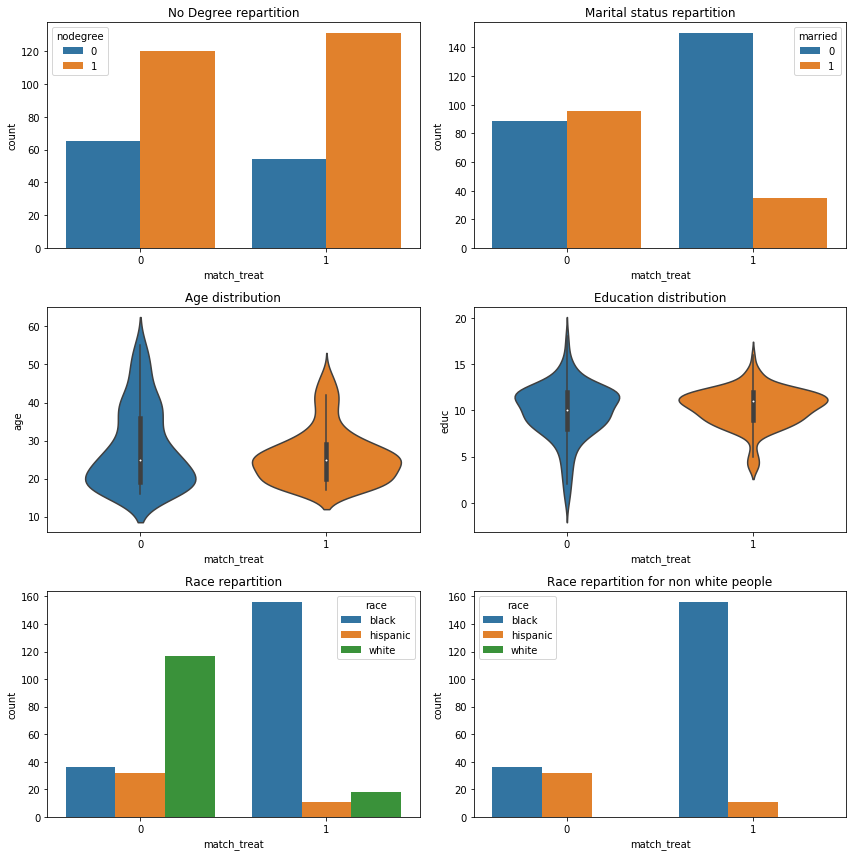

In [34]:
df_tmp = df.loc[df.match_treat != -1]
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

ax[0, 0].set_title("No Degree repartition")
sns.countplot(x='match_treat', hue='nodegree', data=df_tmp, ax=ax[0, 0])

ax[0, 1].set_title("Marital status repartition")
sns.countplot(x='match_treat', hue='married', data=df_tmp, ax=ax[0,1])

ax[1, 0].set_title("Age distribution")
sns.violinplot(x='match_treat', y='age', data=df_tmp, ax=ax[1, 0])

ax[1, 1].set_title("Education distribution")
sns.violinplot(x='match_treat', y='educ', data=df_tmp, ax=ax[1, 1])

ax[2, 0].set_title("Race repartition")
sns.countplot(x='match_treat', hue='race', data=df_tmp, ax=ax[2, 0])

ax[2, 1].set_title("Race repartition for non white people")
sns.countplot(x='match_treat', hue='race', data=df_tmp.loc[df.race != 'white', ['match_treat', 'race']], ax=ax[2, 1])

plt.tight_layout()
plt.show()

Marital statues and race repartition are still not balanced. This need to be improved.

Propensity scores for both groups are not balanced either.

In [35]:
np.mean(df.loc[df.match_treat == 0, 'propensity_score'])

0.1967540855504013

In [36]:
np.mean(df.loc[df.match_treat == 1, 'propensity_score'])

0.56186938296404965

### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

Do the same thing as before but now we only add edges between the nodes that have the same race and the same marital status.

In [52]:
B = nx.Graph()

# add nodes
B.add_nodes_from(nodes_treated, bipartite = 0)
B.add_nodes_from(nodes_control, bipartite = 1)

# add edges and weights
for ind_treated, node_treated in enumerate(nodes_treated):
    for ind_control, node_control in enumerate(nodes_control):
        if df.loc[node_treated, 'race'] == df.loc[node_control, 'race'] and df.loc[node_treated, 'married'] == df.loc[node_control, 'married']:
            propensity_diff = -abs(prop_scores[y==1][ind_treated] - prop_scores[y==0][ind_control])
            B.add_edge(node_treated, node_control, weight = propensity_diff)

print(nx.is_connected(B))
print(nx.is_bipartite(B))

False
True


The graph is not connected anymore. Let's see if each node as at least one neighbor.

In [59]:
nx.isolate.number_of_isolates(B)

0

No node is isolated so we will be able to find a matching.

TODO:
In order to use network x, we need to make the graph connected again. Let's do so by making control and test subgraphs complete (with inner edge weights $\infty$).

### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [38]:
def plot_confusion_matrix(mat):
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(mat, cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)
    plt.show()

#### Import the data

In [39]:
newsgroups_train = fetch_20newsgroups(subset='train')

#### Compute the df-idf matrix

In [40]:
# declare the vectorizer
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
# compute the td-idf features
tfidf = vectorizer.fit_transform(newsgroups_train['data'])
# get the correspondance between features and words
feature_names = vectorizer.get_feature_names()

#### Split data set in train, test and validation tests (80%, 10%, 10%) 

In [41]:
# split in train (80%) and tmp (20%)
X_train, X_tmp, y_train, y_tmp = train_test_split(tfidf, newsgroups_train['target'], test_size=0.2, random_state=42)
# split tmp in test and validation (50% - 50%) ~ (10% - 10%)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

In [42]:
X_train.shape, X_test.shape, X_val.shape

((9051, 129796), (1132, 129796), (1131, 129796))

#### Train the random forest

First we use the default parameters.

In [43]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Predict on test and visualize confusion matrix

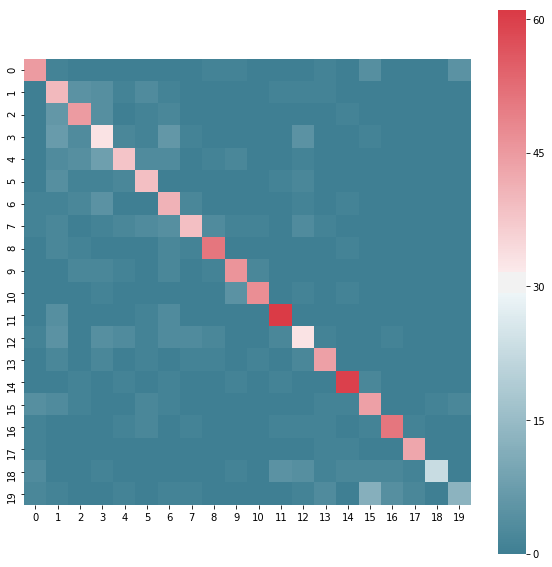

In [44]:
y_predict = clf.predict(X_test)
plot_confusion_matrix(np.asarray(confusion_matrix(y_test, y_predict)))

#### Grid search to find the best parameters

In [45]:
parameters = {'n_estimators':[10, 30, 50, 100, 200], 'max_depth':[10, 20, 50, 100, 200]}
grid_search = GridSearchCV(clf, parameters)

In [46]:
grid_search.fit(X_val, y_val)
grid_search.best_params_

{'max_depth': 200, 'n_estimators': 200}

#### Train and test of the classifier with these parameters

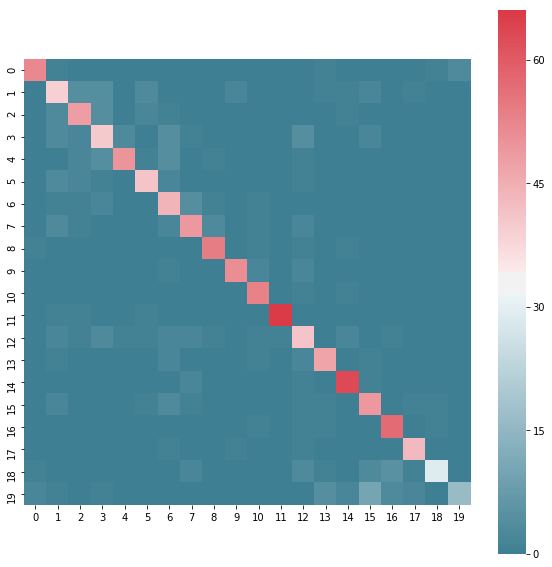

In [47]:
clf = RandomForestClassifier(n_estimators=200, max_depth=50)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

plot_confusion_matrix(np.asarray(confusion_matrix(y_test, y_predict)))

This matrix shows that the prediction is far more accurate using the tuned hyperparameters found by grid search.
Blue is darker outside of the diagonal (less errors of classification).

#### Feature importance

Now let's look at the `feature_importances_` of the classifier and see the correspondance with terms in the text.

We'll look at the 20 more important features and the corresponding terms.

In [48]:
ind = list(np.argsort(clf.feature_importances_)[-20:])

In [49]:
itemgetter(*ind)(feature_names)

('guns',
 'gun',
 'team',
 'mac',
 'motif',
 'hockey',
 'nhl',
 'key',
 'israel',
 'rutgers',
 'space',
 'baseball',
 'encryption',
 'clipper',
 'god',
 'car',
 'bike',
 'dod',
 'windows',
 'sale')

TODO:
- discuss the results
- improve classifications by doing data cleaning (tokenization ?)
- compute score of classification